In [2]:
from collections import deque 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from river import cluster as river_cluster
from sklearn import cluster as sklearn_cluster
from scipy.spatial.distance import cdist
from river import stream
from river.utils import dict2numpy
from collections import Counter
from tqdm import tqdm
import time

# FastCOMPOSE pipeline with improvement 1

In [3]:
class FastCOMPOSE:
    def __init__(self, data, labels, training_set_size, safe_level_num_of_neighbours=7, safe_level_threshold=0.75):
        ### OK
        self.training_set_size = training_set_size
        self.training_set_data = deque()
        self.training_set_labels = deque()
        self.clusters = None
        
        # Set core support extraction parameters
        self.safe_level_num_of_neighbours = safe_level_num_of_neighbours
        self.safe_level_threshold = safe_level_threshold
        
        for i, (x, y) in enumerate(stream.iter_array(data, labels)):
            # Add labeled data to the training set
            self._add_data_to_training_set([(x, y)])
        
        # Initial number of classes serving as lower boundary of possible number of clusters
        self.inital_number_of_classes = len(np.unique(self.training_set_labels))
        
        # Train on training set
        self._train_on_training_set(None)
            
    def _calculate_accuracy(self, data, labels):
        ### OK
        # Calculate accuracy on current batch
        accuracy = 0
        accuracy_per_class = {label: [] for label in np.unique(labels)}
            
        for i, (x, y) in enumerate(stream.iter_array(data, labels)):
            cluster = self.clustering_algorithm.predict(dict2numpy(x).reshape(1, -1))[0]
            y_pred = self.clusters[cluster]["cluster_label"]
            accuracy += (y == y_pred)
            accuracy_per_class[y].append(y == y_pred)
            
        accuracy /= len(data)
        accuracy_per_class = {label: np.mean(scores) for label, scores in accuracy_per_class.items()}
        
        return accuracy, accuracy_per_class
    
    def _calculate_safe_levels(self, labeled_data):
        ### OK
        safe_levels = []
        
        for x, y in labeled_data:
            x = dict2numpy(x)
            dists = cdist([x], self.training_set_data)[0]
            closest_neighbours_idxs = np.argsort(dists)[:self.safe_level_num_of_neighbours]
            closest_neighbours_labels = np.array(self.training_set_labels)[closest_neighbours_idxs]
            safe_level = sum([1 for label in closest_neighbours_labels if label == y])/self.safe_level_num_of_neighbours
            safe_levels.append(safe_level)

        return safe_levels
    
    def _select_core_supports(self, labeled_data):
        ### OK
        safe_levels = self._calculate_safe_levels(labeled_data)
        core_points_idxs = np.where(np.array(safe_levels) > self.safe_level_threshold)
        core_points = np.array(labeled_data)[core_points_idxs].tolist()
        return core_points
            
    def _add_data_to_training_set(self, labeled_data):
        ### OK
        for x, y in labeled_data:
            if self.training_set_size and len(self.training_set_data) == self.training_set_size:
                self.training_set_data.popleft()
                self.training_set_labels.popleft()
            self.training_set_data.append(dict2numpy(x))
            self.training_set_labels.append(y)
            
    def _create_clusters(self, data_from_current_batch):
        ### OK
        self.clusters = {idx: {"data": [], "labels": [], "number_of_examples_from_current_batch": 0, "cluster_label": None} for idx in range(self.n_clusters)}

        for i, (x, y) in enumerate(stream.iter_array(self.training_set_data, self.training_set_labels)):
            cluster = self.clustering_algorithm.labels_[i]
            self.clusters[cluster]["data"].append(x)
            self.clusters[cluster]["labels"].append(y)
            
            if data_from_current_batch and (x, y) in data_from_current_batch:
                self.clusters[cluster]["number_of_examples_from_current_batch"] += 1

        # Label clusters by majority voting
        for cluster_idx in self.clusters.keys():
            cluster_label = max(set(self.clusters[cluster_idx]["labels"]),
                                key=self.clusters[cluster_idx]["labels"].count)
            self.clusters[cluster_idx]["cluster_label"] = cluster_label
            
        # Retrain with smaller number of clusters if created clusters only with examples from current batch
        if np.any([len(cluster["data"]) == cluster["number_of_examples_from_current_batch"] for idx, cluster in self.clusters.items()]):
            return 1

        return 0
    
    def _train_on_training_set(self, data_from_current_batch):
        ### OK
        previous_clusters = self.clusters
        
        self.n_clusters = 5
        self.clustering_algorithm = sklearn_cluster.KMeans(n_clusters=self.n_clusters)
        
        self.clustering_algorithm = self.clustering_algorithm.fit(self.training_set_data)
        retrain = self._create_clusters(data_from_current_batch)
            
        # If some clusters contain only data from current batch retrain model with smaller number of clusters
        while retrain and self.n_clusters > self.inital_number_of_classes:
            self.n_clusters -= 1
            self.clustering_algorithm = sklearn_cluster.KMeans(n_clusters=self.n_clusters)
            
            print(f"Number of clusters = {self.n_clusters}")
            
            self.clustering_algorithm = self.clustering_algorithm.fit(self.training_set_data)
            retrain = self._create_clusters(data_from_current_batch)
            
        # If some class is going to be lost keep it in the cluster with the highest proportion of this class
        if previous_clusters:
            classes_in_current_clusters = np.unique(
                [cluster["cluster_label"] for cluster in list(self.clusters.values())])
            classes_in_previous_clusters = np.unique(
                [cluster["cluster_label"] for cluster in list(previous_clusters.values())])

            if not np.array_equal(classes_in_current_clusters, classes_in_previous_clusters) and len(self.clusters) == len(previous_clusters):
                for class_ in classes_in_previous_clusters:
                    if class_ not in classes_in_current_clusters:
                        missing_class_proportions = {idx: Counter(cluster["labels"])[class_] / len(cluster["labels"])
                                                     for idx, cluster in list(self.clusters.items())}
                        cluster_to_keep_class = max(missing_class_proportions, key=missing_class_proportions.get)
                        self.clusters[cluster_to_keep_class]["cluster_label"] = class_
            
    def _cluster_and_label_step(self, data, labels):
        ### OK
        data_with_labels = []
        
        for i, (x, _) in enumerate(stream.iter_array(data, labels)):   
            cluster = self.clustering_algorithm.predict(dict2numpy(x).reshape(1, -1))[0]
            y = self.clusters[cluster]["cluster_label"]
            data_with_labels.append((x, y))
            
        core_points = self._select_core_supports(data_with_labels)
        
        # Add newly labeled core points to the training set
        self._add_data_to_training_set(core_points)
        
        self._train_on_training_set(core_points)
        
    def plot_clusters(self, print_label_counts_in_clusters):  
        ### OK
        data_dim = self.training_set_data[0].shape[0]
            
        # Plot 3D data
        if data_dim == 3:
            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')

        for idx, cluster in self.clusters.items():
            labels = cluster["labels"]
            # Skip empty clusters
            if len(labels) == 0:
                continue
            label = cluster["cluster_label"]
            cluster = np.vstack([list(data_element.values()) for data_element in cluster["data"]])
            # Plot 3D data
            if data_dim == 3:
                ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], label=label)
            # Plot 2D data
            else:
                plt.scatter(cluster[:, 0], cluster[:, 1], label=label)
                
            if print_label_counts_in_clusters:
                counter = Counter(labels)
                print(dict(counter))
        
        plt.title("Clusters from training set with labels")
        plt.legend()
        plt.show()
                    
    def __call__(self, data, labels):
        ### OK
        self._cluster_and_label_step(data, labels)
        accuracy, accuracy_per_class = self._calculate_accuracy(data, labels)
        return accuracy, accuracy_per_class

In [4]:
def plot_incoming_data(data, labels):
    unique_labels = np.unique(labels)
    data_dim = data.shape[1]
    
    # Plot 3D data
    if data.shape[1] == 3:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
    
    for label in unique_labels:
        # Plot 3D data
        if data_dim == 3:
            ax.scatter(data[labels == label][:, 0], data[labels == label][:, 1], data[labels == label][:, 2], label=label)
        # Plot 2D data
        else:
            plt.scatter(data[labels == label][:, 0], data[labels == label][:, 1], label=label)
    
    plt.title("Data from current batch with labels")
    plt.legend()
    plt.show()

In [5]:
def train_fast_compose(streaming_data, streaming_labels, training_set_size=1000, print_interval=50, print_label_counts_in_clusters=False):
    # Assume first batch (streaming_data[0], streaming_labels[0]) to be labelled to initialize algorithm
    accuracies = []
    accuracies_per_class = {label: [] for label in np.unique(streaming_labels)}
    start = time.time()

    fc = FastCOMPOSE(streaming_data[0], streaming_labels[0], training_set_size)

    for batch_idx, (data, labels) in tqdm(enumerate(zip(streaming_data[1:], streaming_labels[1:]), 1)):
        accuracy, accuracy_per_class = fc(data, labels)
        accuracies.append(accuracy)
        for label, accuracy in accuracy_per_class.items():
            accuracies_per_class[label].append(accuracy)
        # If class not present in current batch set accuracy for that class to None
        for label in accuracies_per_class.keys():
            if label not in accuracy_per_class.keys():
                accuracies_per_class[label].append(None)

    #     print(batch_idx, accuracy)

        if batch_idx % print_interval == 0:
            fc.plot_clusters(print_label_counts_in_clusters)
            plot_incoming_data(data, labels)

    end = time.time()
    print(f"Time elapsed: {end - start}")
    
    plt.plot(accuracies)
    plt.title("Accuracy")
    plt.show()
    
    for label, accuracy in accuracies_per_class.items():
        plt.plot(accuracy, label=f"{label}")
    plt.title("Accuracy per class")
    plt.legend()
    plt.show()
    
    return fc, accuracies, accuracies_per_class

# Experiments 2D

In [6]:
dataset_2d = "./2d_gaussian_data_v2.csv"

In [7]:
gaussian_data_2d = pd.read_csv(dataset_2d)
y_2d = gaussian_data_2d.pop('label').to_numpy()
X_2d = gaussian_data_2d.to_numpy()

In [8]:
X_2d.shape

(26300, 2)

In [9]:
y_2d.shape

(26300,)

In [10]:
for xi, yi in stream.iter_array(X_2d, y_2d):
    print(xi, yi)
    break

{0: 1.3084041099825865, 1: 5.271207619270895} 0


In [11]:
streaming_data_2d = np.split(X_2d, X_2d.shape[0]/100)
streaming_labels_2d = np.split(y_2d, y_2d.shape[0]/100)

In [12]:
streaming_data_2d[0].shape

(100, 2)

In [13]:
streaming_labels_2d[0].shape

(100,)

49it [00:17,  2.44it/s]

{0: 227}
{1: 520}
{1: 240}
{0: 241, 1: 3}
{0: 259, 1: 10}


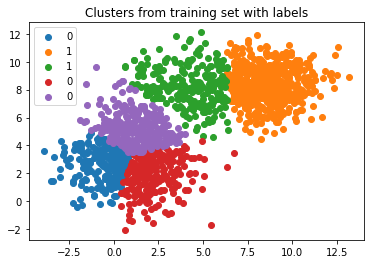

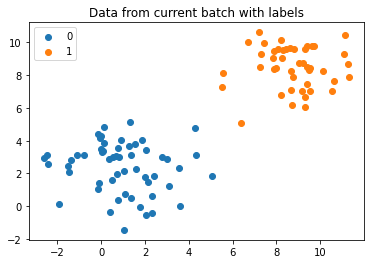

99it [00:36,  2.63it/s]

{0: 294}
{1: 300}
{1: 22, 0: 284}
{0: 269}
{1: 331}


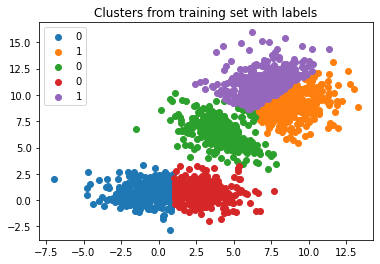

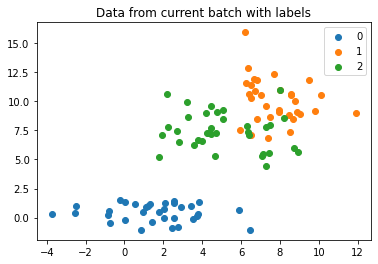

149it [00:56,  2.68it/s]

{0: 203, 1: 2}
{1: 530, 0: 2}
{0: 275}
{0: 136}
{0: 351, 1: 1}


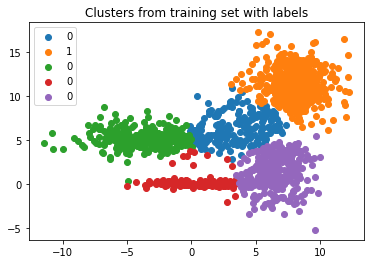

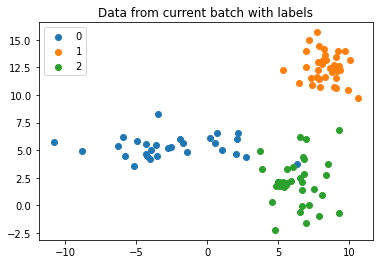

199it [01:19,  2.37it/s]

{1: 489}
{0: 302}
{0: 240}
{0: 278}
{0: 191}


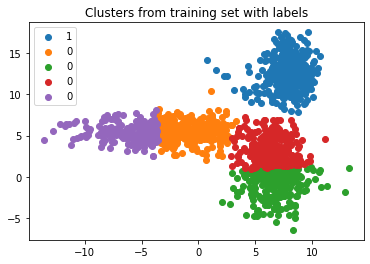

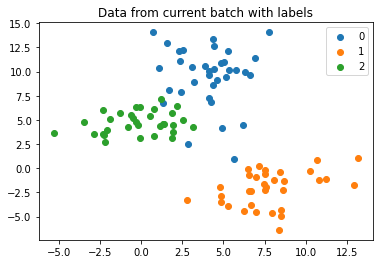

249it [01:41,  2.61it/s]

{0: 226}
{0: 368, 1: 1}
{1: 297, 0: 3}
{0: 285}
{0: 319, 1: 1}


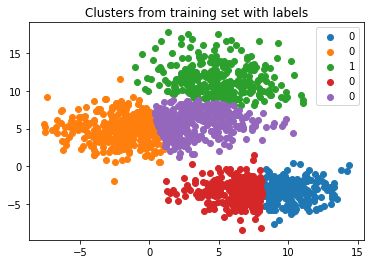

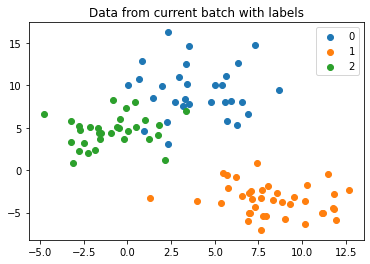

262it [01:46,  2.47it/s]

Time elapsed: 106.33103585243225


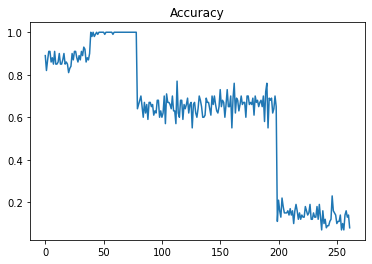

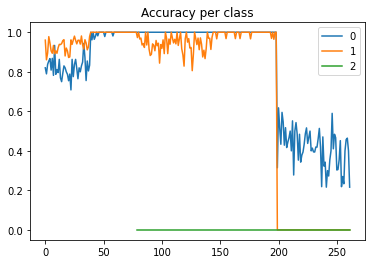

In [14]:
fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_2d, streaming_labels_2d, training_set_size=1500, print_interval=50, print_label_counts_in_clusters=True)

262it [01:51,  2.35it/s]

Time elapsed: 111.64991426467896


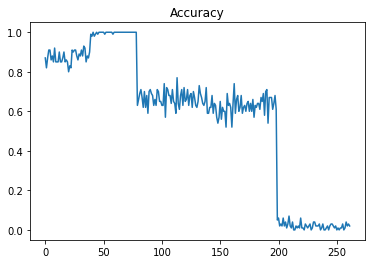

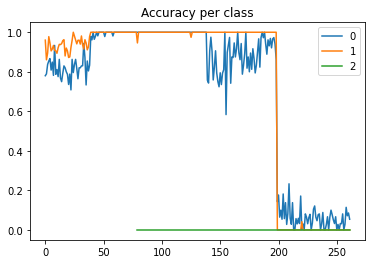

262it [01:50,  2.37it/s]

Time elapsed: 110.77150702476501


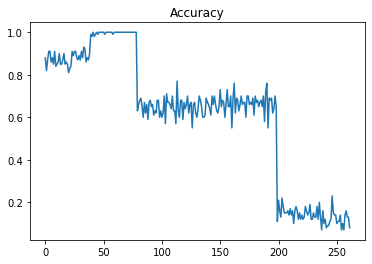

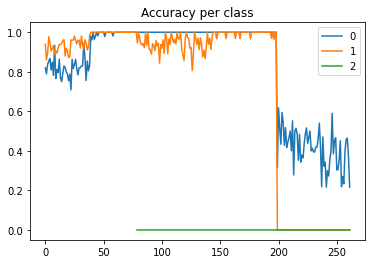

262it [01:53,  2.32it/s]

Time elapsed: 113.18813610076904


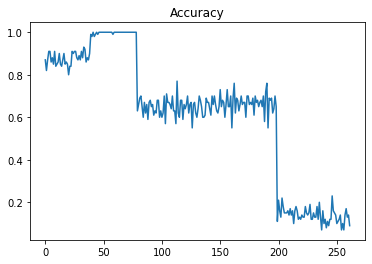

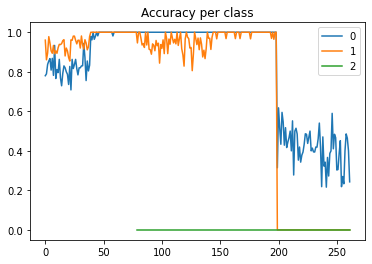

262it [01:34,  2.76it/s]

Time elapsed: 94.80510807037354


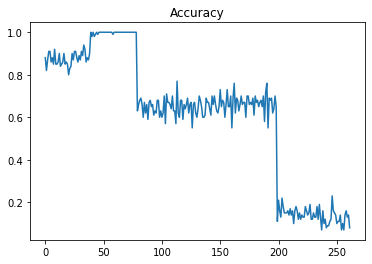

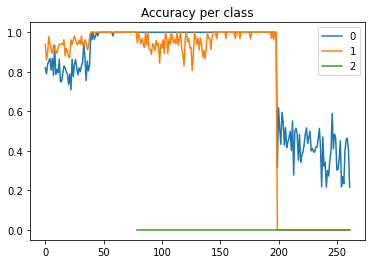

262it [01:39,  2.64it/s]

Time elapsed: 99.1787838935852


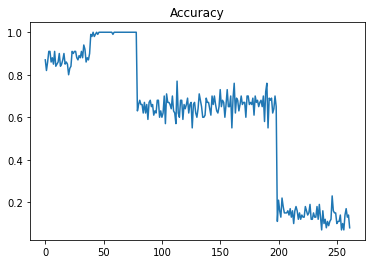

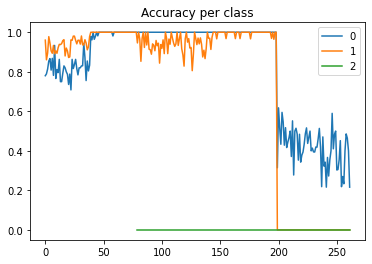

In [15]:
# Obtain averaged results
accuracy_results = []
accuracy_per_class_results = []
for i in range(5):
    fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_2d, streaming_labels_2d, training_set_size=1500, print_interval=1000, print_label_counts_in_clusters=False)
    accuracy_results.append(accuracies)
    accuracy_per_class_results.append(accuracies_per_class)

Text(0.5, 1.0, 'Accuracy averaged over 5 learning trials')

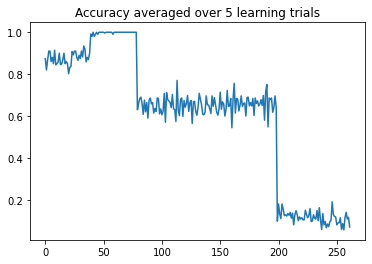

In [16]:
plt.plot(np.array(accuracy_results).mean(axis=0))
plt.title("Accuracy averaged over 5 learning trials")

In [17]:
avg_results_per_class = []
for class_ in range(3):
    result_per_class = np.array([dict_[class_] for dict_ in accuracy_per_class_results if class_ in dict_.keys()], dtype=float)
    avg_result_per_class = np.nanmean(result_per_class, axis=0)
    avg_results_per_class.append(avg_result_per_class)

<ipython-input-17-9865dfc5f3b5>:4: RuntimeWarning: Mean of empty slice
  avg_result_per_class = np.nanmean(result_per_class, axis=0)


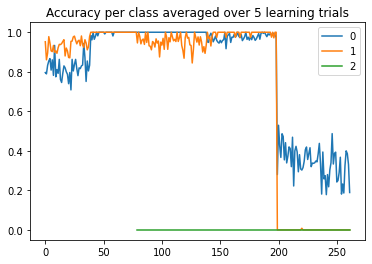

In [18]:
for class_ in range(3):
    plt.plot(avg_results_per_class[class_], label=class_)
    plt.legend()
    plt.title("Accuracy per class averaged over 5 learning trials")

# Experiments 3D

In [19]:
dataset_3d = "./3d_gaussian_data.csv"
gaussian_data_3d = pd.read_csv(dataset_3d)
y_3d = gaussian_data_3d.pop('label').to_numpy()
X_3d = gaussian_data_3d.to_numpy()

In [20]:
X_3d.shape

(20200, 3)

In [21]:
y_3d.shape

(20200,)

In [22]:
for xi, yi in stream.iter_array(X_3d, y_3d):
    print(xi, yi)
    break

{0: 8.065993314520647, 1: 2.252267979768172, 2: 5.110438424631312} 0


In [23]:
streaming_data_3d = np.split(X_3d, X_3d.shape[0]/100)
streaming_labels_3d = np.split(y_3d, y_3d.shape[0]/100)

In [24]:
streaming_data_3d[0].shape

(100, 3)

In [25]:
streaming_labels_3d[0].shape

(100,)

49it [00:19,  2.67it/s]

{0: 312}
{1: 254}
{0: 233, 1: 1}
{0: 242}
{1: 457, 0: 1}


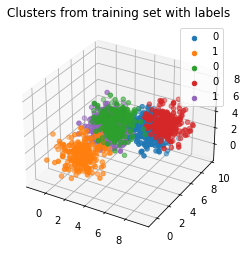

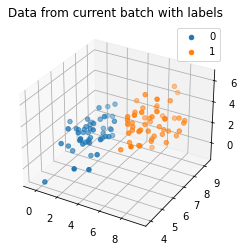

99it [00:41,  2.57it/s]

{1: 225}
{0: 388}
{1: 280}
{1: 244}
{0: 363}


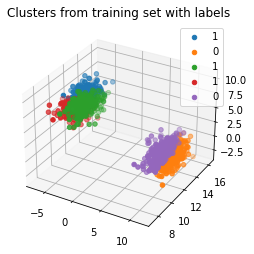

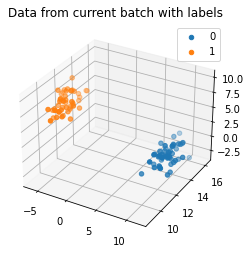

149it [01:01,  2.01it/s]

{0: 257}
{0: 355}
{0: 253}
{0: 302}
{0: 333}


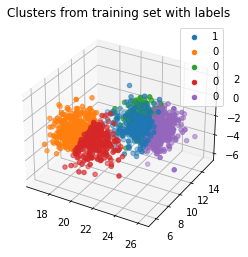

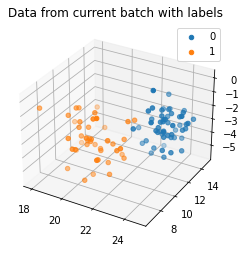

199it [01:21,  2.68it/s]

{0: 214}
{0: 381}
{0: 289}
{0: 379}
{0: 237}


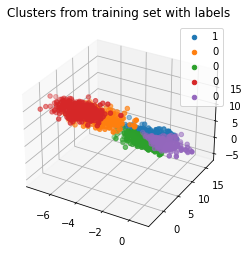

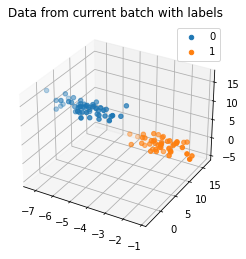

201it [01:22,  2.43it/s]

Time elapsed: 82.78690695762634


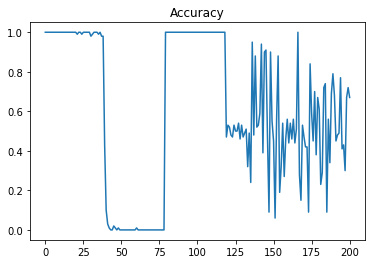

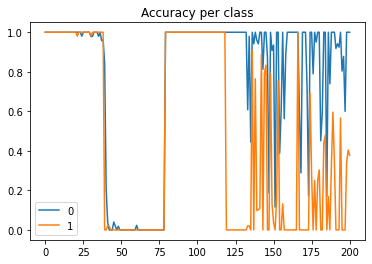

In [26]:
fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_3d, streaming_labels_3d, training_set_size=1500, print_interval=50, print_label_counts_in_clusters=True)

201it [01:23,  2.40it/s]


Time elapsed: 83.89733004570007


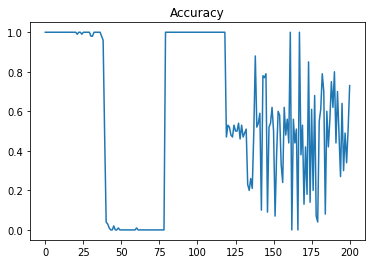

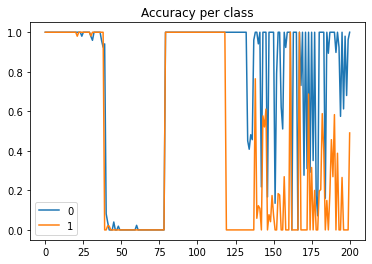

201it [01:23,  2.40it/s]

Time elapsed: 83.64032411575317


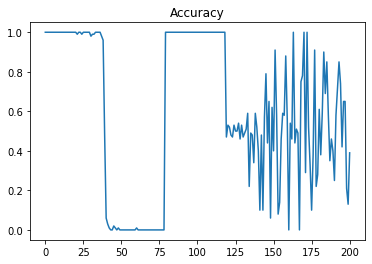

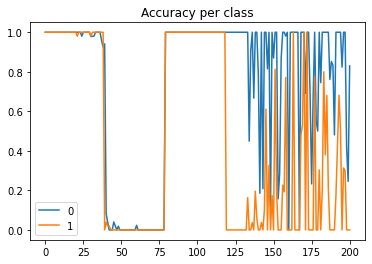

201it [01:26,  2.31it/s]

Time elapsed: 86.9274332523346


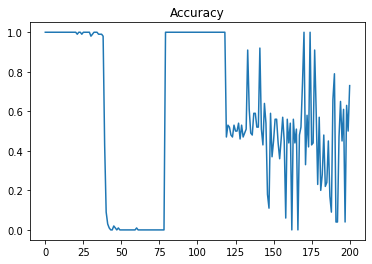

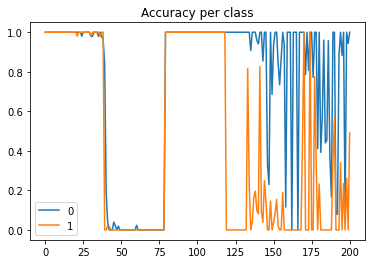

201it [01:25,  2.36it/s]

Time elapsed: 85.34642601013184


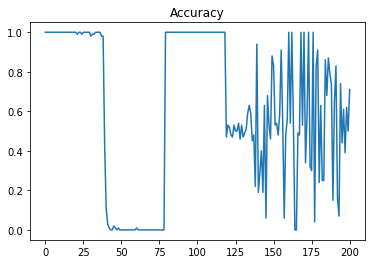

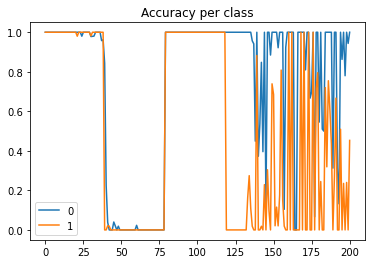

201it [01:19,  2.52it/s]

Time elapsed: 79.8467230796814


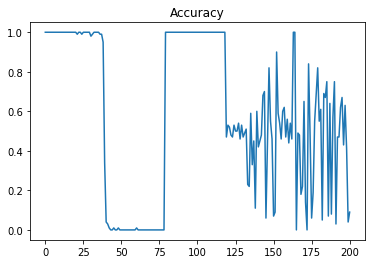

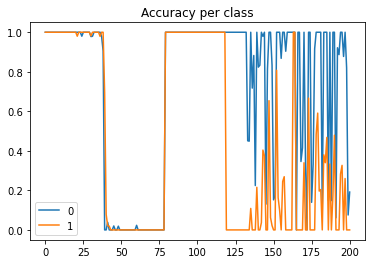

In [27]:
# Obtain averaged results
accuracy_results = []
accuracy_per_class_results = []
for i in range(5):
    fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_3d, streaming_labels_3d, training_set_size=1500, print_interval=1000, print_label_counts_in_clusters=False)
    accuracy_results.append(accuracies)
    accuracy_per_class_results.append(accuracies_per_class)

Text(0.5, 1.0, 'Accuracy averaged over 5 learning trials')

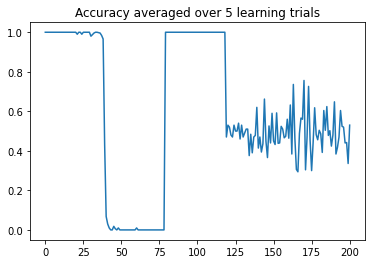

In [28]:
plt.plot(np.array(accuracy_results).mean(axis=0))
plt.title("Accuracy averaged over 5 learning trials")

In [29]:
avg_results_per_class = []
for class_ in range(2):
    result_per_class = np.array([dict_[class_] for dict_ in accuracy_per_class_results if class_ in dict_.keys()], dtype=float)
    avg_result_per_class = np.nanmean(result_per_class, axis=0)
    avg_results_per_class.append(avg_result_per_class)

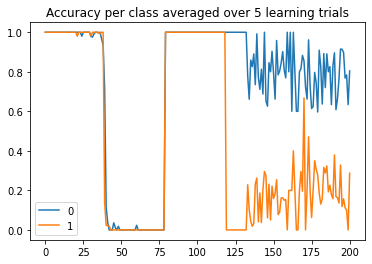

In [30]:
for class_ in range(2):
    plt.plot(avg_results_per_class[class_], label=class_)
    plt.legend()
    plt.title("Accuracy per class averaged over 5 learning trials")

# Experiments 3D with added class

In [31]:
dataset_3d = "./3d_gaussian_data_added_class.csv"
gaussian_data_3d = pd.read_csv(dataset_3d)
y_3d = gaussian_data_3d.pop('label').to_numpy()
X_3d = gaussian_data_3d.to_numpy()

In [32]:
X_3d.shape

(30300, 3)

In [33]:
y_3d.shape

(30300,)

In [34]:
for xi, yi in stream.iter_array(X_3d, y_3d):
    print(xi, yi)
    break

{0: -1.0151555241479664, 1: -1.4161182780401813, 2: 1.951098984742738} 1


In [35]:
streaming_data_3d = np.split(X_3d, X_3d.shape[0]/100)
streaming_labels_3d = np.split(y_3d, y_3d.shape[0]/100)

In [36]:
streaming_data_3d[0].shape

(100, 3)

In [37]:
streaming_labels_3d[0].shape

(100,)

49it [00:19,  2.43it/s]

{2: 302}
{0: 261}
{1: 471, 2: 2}
{2: 222}
{0: 240, 2: 1, 1: 1}


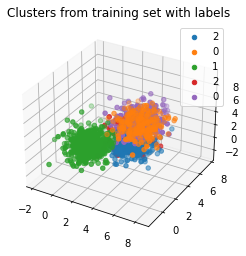

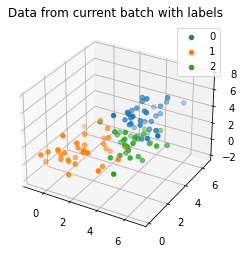

99it [00:40,  2.56it/s]

{0: 277}
{2: 270}
{1: 422, 0: 14, 2: 1}
{0: 251}
{2: 265}


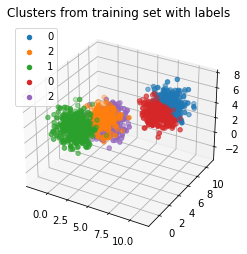

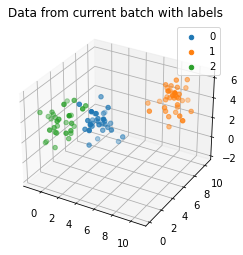

149it [00:59,  2.71it/s]

{0: 292}
{0: 272}
{2: 439}
{0: 203}
{0: 294}


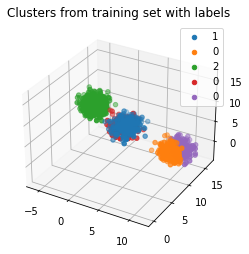

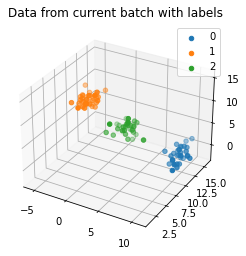

199it [01:18,  2.59it/s]

{0: 282}
{0: 304}
{0: 291}
{0: 333}
{0: 290}


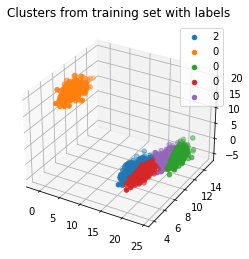

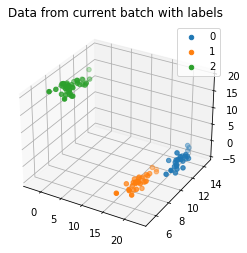

249it [01:37,  3.14it/s]

{0: 334}
{0: 367}
{0: 299}
{0: 201}
{0: 299}


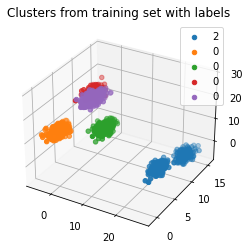

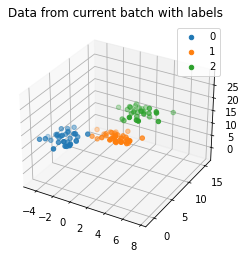

299it [01:57,  2.87it/s]

{0: 235}
{0: 489}
{0: 276}
{0: 271}
{0: 229}


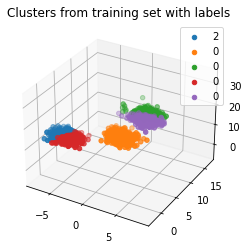

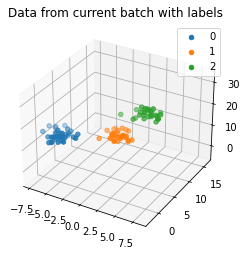

302it [01:58,  2.55it/s]

Time elapsed: 118.5925030708313


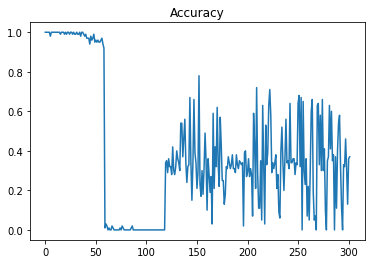

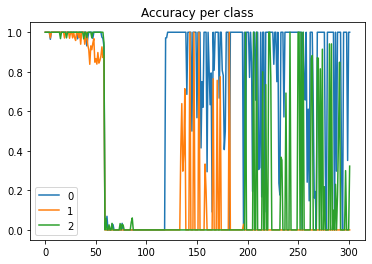

In [38]:
fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_3d, streaming_labels_3d, training_set_size=1500, print_interval=50, print_label_counts_in_clusters=True)

302it [01:54,  2.65it/s]

Time elapsed: 114.08284497261047


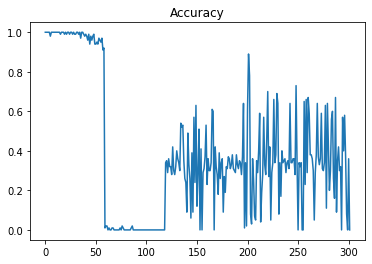

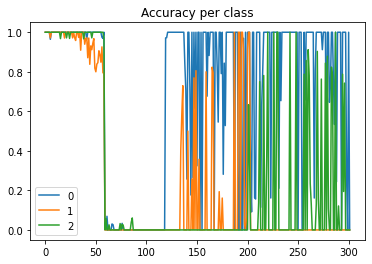

302it [01:54,  2.63it/s]

Time elapsed: 114.83773279190063


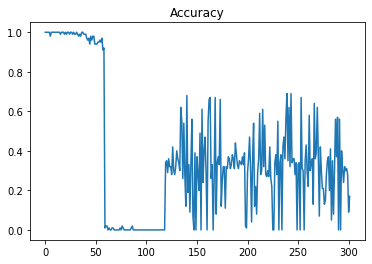

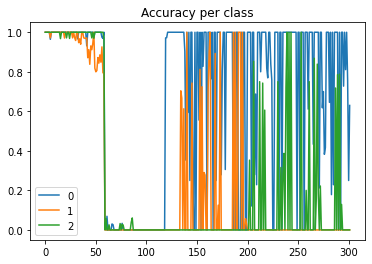

302it [02:03,  2.44it/s]

Time elapsed: 123.95075607299805


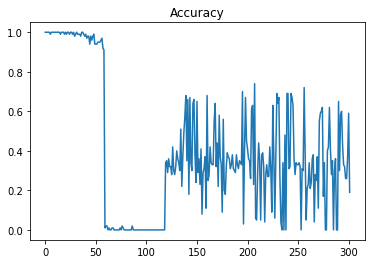

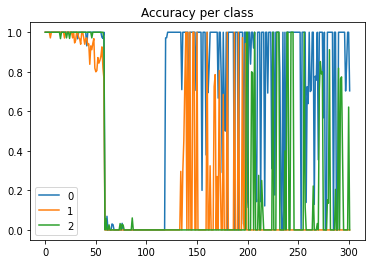

302it [01:55,  2.62it/s]

Time elapsed: 115.50877022743225


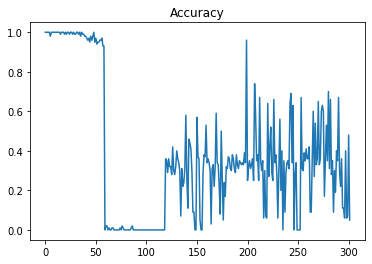

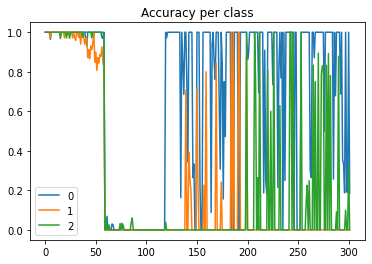

302it [01:55,  2.61it/s]

Time elapsed: 115.69523119926453


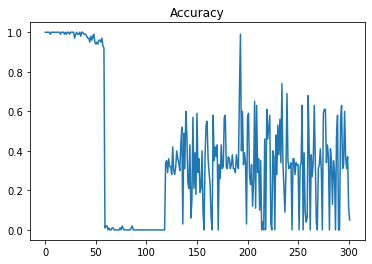

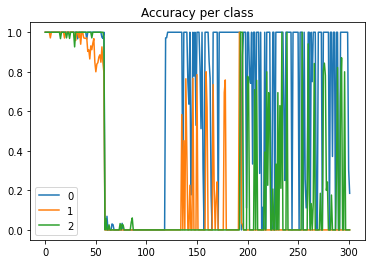

In [39]:
# Obtain averaged results
accuracy_results = []
accuracy_per_class_results = []
for i in range(5):
    fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_3d, streaming_labels_3d, training_set_size=1500, print_interval=1000, print_label_counts_in_clusters=False)
    accuracy_results.append(accuracies)
    accuracy_per_class_results.append(accuracies_per_class)

Text(0.5, 1.0, 'Accuracy averaged over 5 learning trials')

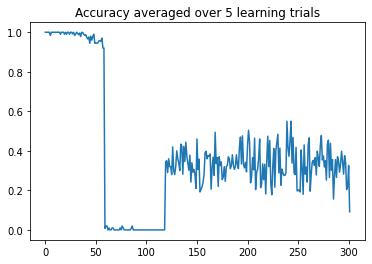

In [40]:
plt.plot(np.array(accuracy_results).mean(axis=0))
plt.title("Accuracy averaged over 5 learning trials")

In [41]:
avg_results_per_class = []
for class_ in range(3):
    result_per_class = np.array([dict_[class_] for dict_ in accuracy_per_class_results if class_ in dict_.keys()], dtype=float)
    avg_result_per_class = np.nanmean(result_per_class, axis=0)
    avg_results_per_class.append(avg_result_per_class)

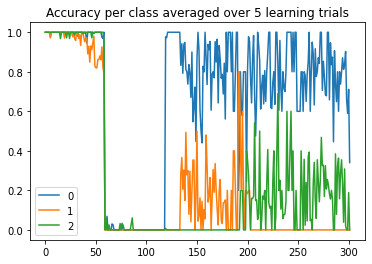

In [42]:
for class_ in range(3):
    plt.plot(avg_results_per_class[class_], label=class_)
    plt.legend()
    plt.title("Accuracy per class averaged over 5 learning trials")